<a href="https://colab.research.google.com/github/alinespereira/alshenawy-distribution/blob/main/Alshenawy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rich

In [ ]:
%%bash
rm -rf distributions stats
git clone https://github.com/alinespereira/alshenawy-distribution
mv alshenawy-distribution/distributions .
mv alshenawy-distribution/stats .
rm -rf alshenawy-distribution

In [ ]:
%%bash
pip install --upgrade pymc arviz numpy pandas scipy matplotlib seaborn tqdm numpyro jax

In [2]:
from pathlib import Path

for path in [
    Path("./img/classical/sim"),
    Path("./img/classical/application"),
    Path("./res/classical/sim"),
    Path("./res/classical/application"),

    Path("./img/bayesian/sim/uninformative"),
    Path("./img/bayesian/sim/informative"),
    Path("./img/bayesian/application/uninformative"),
    Path("./img/bayesian/application/informative"),

    Path("./res/bayesian/sim/uninformative"),
    Path("./res/bayesian/sim/informative"),
    Path("./res/bayesian/application/uninformative"),
    Path("./res/bayesian/application/informative"),
]:
    try:
        path.mkdir(mode=0o755, parents=True)
    except FileExistsError:
        pass

In [3]:
import os

import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats, optimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from distributions.rv import a
from distributions.continuous import A
from stats import classical, bayesian
from stats.utils import summarize

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
plt.style.use("arviz-darkgrid")

# Estudo de simulação

In [5]:
REPLICATIONS: int = 1_000
SAMPLE_SIZES: list[int] = [25, 50, 100, 200, 400]
BETAS: list[float] = [0.125, 0.6, 1.0]
ALPHA: float = 0.05

In [6]:
RANDOM_SEED: int = 42
RNG: np.random.Generator = np.random.default_rng(RANDOM_SEED)

# Estudo de simulação clássico

In [7]:
%%time
simulations = {}
np.random.seed(RANDOM_SEED)

for beta in BETAS:
    simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        simulations[beta][n] = []
        print(f"\t{n = }")
        for i in tqdm(range(REPLICATIONS)):
            sample = rv.rvs(size=n)
            negative_log_likelihood = lambda beta_: -a(beta=beta_[0]).logpdf(sample).sum()
            simulation = classical.simulate(
                param=beta,
                negative_log_likelihood=negative_log_likelihood,
                initial_guess=0.05,
                sample_size=len(sample),
                alpha=ALPHA,
                method='L-BFGS-B',
                options={'gtol': 1e-6}
            )
            simulations[beta][n].append(simulation)

beta = 0.125
	n = 25


100%|███████████████████████| 1000/1000 [00:21<00:00, 46.24it/s]


	n = 50


100%|███████████████████████| 1000/1000 [00:19<00:00, 51.14it/s]


	n = 100


100%|███████████████████████| 1000/1000 [00:18<00:00, 54.66it/s]


	n = 200


100%|███████████████████████| 1000/1000 [00:16<00:00, 58.86it/s]


	n = 400


100%|███████████████████████| 1000/1000 [00:16<00:00, 61.47it/s]


beta = 0.6
	n = 25


100%|███████████████████████| 1000/1000 [00:17<00:00, 57.81it/s]


	n = 50


100%|███████████████████████| 1000/1000 [00:17<00:00, 57.82it/s]


	n = 100


100%|███████████████████████| 1000/1000 [00:17<00:00, 56.46it/s]


	n = 200


100%|███████████████████████| 1000/1000 [00:17<00:00, 57.78it/s]


	n = 400


100%|███████████████████████| 1000/1000 [00:17<00:00, 56.62it/s]


beta = 1.0
	n = 25


100%|███████████████████████| 1000/1000 [00:16<00:00, 60.71it/s]


	n = 50


100%|███████████████████████| 1000/1000 [00:16<00:00, 61.47it/s]


	n = 100


100%|███████████████████████| 1000/1000 [00:15<00:00, 63.24it/s]


	n = 200


100%|███████████████████████| 1000/1000 [00:16<00:00, 60.48it/s]


	n = 400


100%|███████████████████████| 1000/1000 [00:16<00:00, 60.00it/s]

CPU times: user 4min 12s, sys: 12.2 s, total: 4min 24s
Wall time: 4min 21s


In [8]:
summaries = pd.DataFrame([
    summarize(simulations[beta][n])
    for beta in simulations
    for n in simulations[beta]
])

In [9]:
summaries.to_csv("res/classical/sim/summaries.csv", index=False)
summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,0.125,25,0.227360,0.102360,0.049155,0.944
1,0.125,50,0.181848,0.056848,0.020630,0.947
2,0.125,100,0.149499,0.024499,0.007185,0.960
3,0.125,200,0.137687,0.012687,0.003454,0.962
4,0.125,400,0.131544,0.006544,0.001724,0.970
5,0.600,25,0.705931,0.105931,0.089696,0.939
6,0.600,50,0.644072,0.044072,0.035393,0.941
7,0.600,100,0.620665,0.020665,0.015287,0.943
8,0.600,200,0.612981,0.012981,0.006964,0.957
9,0.600,400,0.604833,0.004833,0.003613,0.947


In [10]:
simulation_results = pd.DataFrame([
    simulation
    for beta in simulations
    for n in simulations[beta]
    for simulation in simulations[beta][n]
])
ci = (
    pd.json_normalize(simulation_results["ci"])
    .rename(columns=lambda col: f"ci_{col}")
)
simulation_results[ci.columns] = ci
simulation_results = simulation_results.drop("ci", axis=1)
simulation_results.to_csv("res/classical/sim/simulations.csv", index=False)
simulation_results

,sample_size,true_param,estimated_param,ci_lower,ci_upper
0,25,0.125,0.174616,-0.152515,0.501748
1,25,0.125,0.138236,-0.188764,0.465236
2,25,0.125,0.050000,-1.909964,2.009964
3,25,0.125,0.150530,-0.181397,0.482457
4,25,0.125,0.214025,-0.145065,0.573116
...,...,...,...,...,...
14995,400,1.000,1.077534,0.940183,1.214884
14996,400,1.000,0.993804,0.857534,1.130074
14997,400,1.000,1.003022,0.869101,1.136942
14998,400,1.000,1.042162,0.907525,1.176799


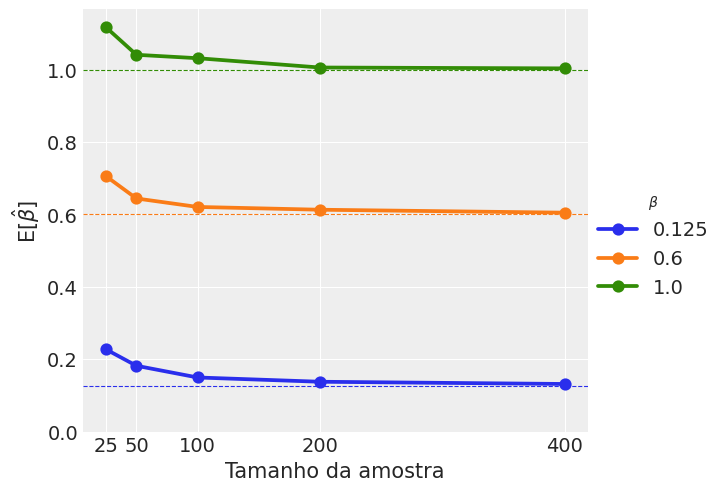

In [11]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="mean", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{E}[\hat{\beta}]$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

for label, color in zip(labels, sns.color_palette()):
    ax.axhline(float(label), color=color, linestyle="--", linewidth=0.8)

fig.savefig("img/classical/sim/mean.png")

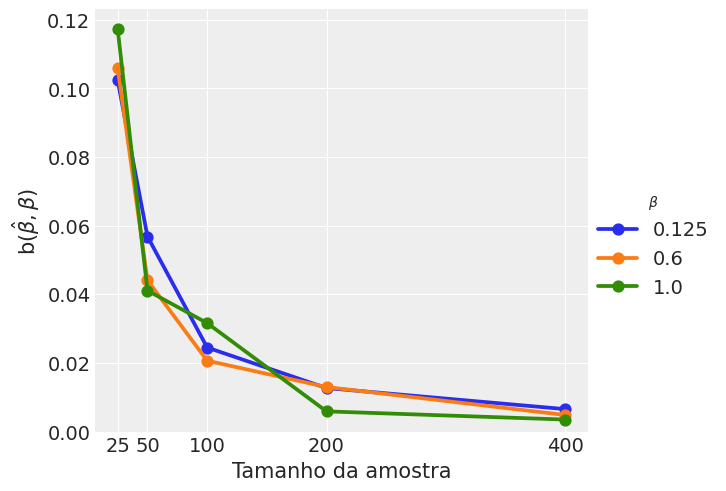

In [12]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="bias", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{b}(\hat{\beta}, \beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/classical/sim/bias.png")

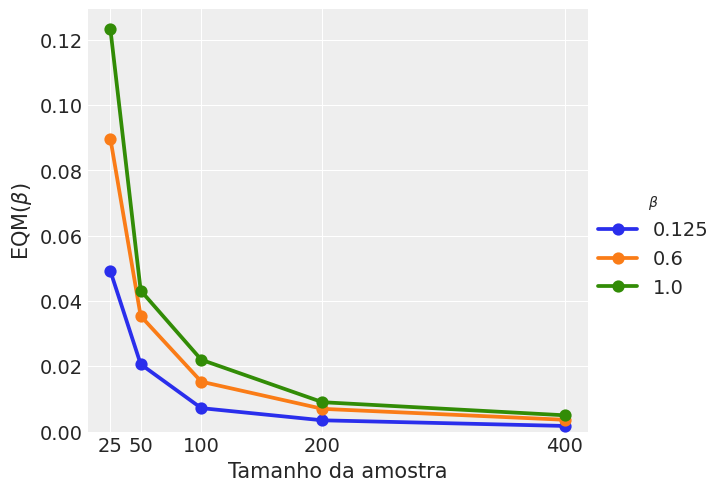

In [13]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="mse", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{EQM}(\beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/classical/sim/eqm.png")

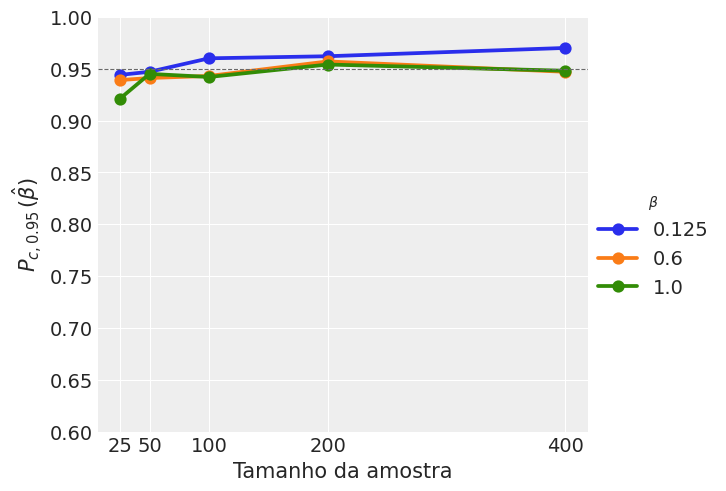

In [14]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="coverage_probability", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(f"$\\operatorname{{P_{{c, {1 - ALPHA:.2f}}}}}(\\hat{{\\beta}})$")

ax.set_ylim(0.6, 1.)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

ax.axhline(1 - ALPHA, color="dimgrey", linestyle="--", linewidth=0.8)

fig.savefig("img/classical/sim/pc.png")

# Estudo de simulação bayesiano

## Priori $\operatorname{Gama}(0.01, 0.001)$

\begin{align*}
    \beta &\sim \operatorname{Gama}(0.01, 0.001) \\
    X &\sim \operatorname{A}(\beta)
\end{align*}

In [ ]:
%%time
uninformative_simulations = {}

for beta in BETAS:
    uninformative_simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        uninformative_simulations[beta][n] = []
        print(f"\t{n = }")
        model = bayesian.make_model(
            sample = rv.rvs(size=n),
            prior=pm.Gamma,
            prior_params={"name": "beta", "alpha": 1, "beta": 1},
        )
        for i in tqdm(range(REPLICATIONS)):
            sample = rv.rvs(size=n)
            simulation = bayesian.simulate(
                param=beta,
                sample=sample,
                model=model,
                alpha=.05,
                sampler_params={
                    "draws": 1000,
                    "chains": 2,
                    "tune": 1000,
                    "target_accept": .99,
                    "random_seed": RNG,
                    "cores": os.cpu_count(),
                    "nuts_sampler": "numpyro",
                    "progressbar": False
                }
            )
            uninformative_simulations[beta][n].append(simulation)

beta = 0.125
	n = 25


 33%|███████▊                | 327/1000 [33:53<43:09,  3.85s/it]

In [ ]:
uninformative_summaries = pd.DataFrame([
    summarize(uninformative_simulations[beta][n])
    for beta in uninformative_simulations
    for n in uninformative_simulations[beta]
])

In [ ]:
uninformative_summaries.to_csv("res/bayesian/sim/uninformative/summaries.csv", index=False)
uninformative_summaries

In [ ]:
simulation_results = pd.DataFrame([
    simulation
    for beta in uninformative_simulations
    for n in uninformative_simulations[beta]
    for simulation in uninformative_simulations[beta][n]
])
ci = (
    pd.json_normalize(simulation_results["ci"])
    .rename(columns=lambda col: f"ci_{col}")
)
simulation_results[ci.columns] = ci
simulation_results = simulation_results.drop("ci", axis=1)
simulation_results.to_csv("res/bayesian/sim/uninformative/simulations.csv", index=False)
simulation_results

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="mean", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{E}[\hat{\beta}]$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

for label, color in zip(labels, sns.color_palette()):
    ax.axhline(float(label), color=color, linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/mean.png")

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries,
              x="sample_size", 
              y="bias", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{b}(\hat{\beta}, \beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/bias.png")

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="mse", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{EQM}(\beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/eqm.png")

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="coverage_probability", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(f"$\\operatorname{{P_{{c, {1 - ALPHA:.2f}}}}}(\\hat{{\\beta}})$")

ax.set_ylim(0.6, 1.)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

ax.axhline(1 - ALPHA, color="dimgrey", linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/pc.png")

## Priori $\operatorname{Gama}(1, 0.5)$

\begin{align*}
    \beta &\sim \operatorname{Gama}(1, 0.5) \\
    X &\sim \operatorname{A}(\beta)
\end{align*}

In [ ]:
%%time
informative_simulations = {}

for beta in BETAS:
    informative_simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        informative_simulations[beta][n] = []
        print(f"\t{n = }")
        model = bayesian.make_model(
            sample = rv.rvs(size=n),
            prior=pm.Gamma,
            prior_params={"name": "beta", "alpha": 1, "beta": 1},
        )
        for i in tqdm(range(REPLICATIONS)):
            sample = rv.rvs(size=n)
            simulation = bayesian.simulate(
                param=beta,
                sample=sample,
                model=model,
                alpha=.05,
                sampler_params={
                    "draws": 1000,
                    "chains": 2,
                    "tune": 1000,
                    "target_accept": .99,
                    "random_seed": RNG,
                    "cores": os.cpu_count(),
                    "nuts_sampler": "numpyro",
                    "progressbar": False
                }
            )
            informative_simulations[beta][n].append(simulation)

In [ ]:
informative_summaries = pd.DataFrame([
    summarize(informative_simulations[beta][n])
    for beta in informative_simulations
    for n in informative_simulations[beta]
])

In [ ]:
informative_summaries.to_csv("res/bayesian/sim/informative/summaries.csv", index=False)
informative_summaries

In [ ]:
simulation_results = pd.DataFrame([
    simulation
    for beta in informative_simulations
    for n in informative_simulations[beta]
    for simulation in informative_simulations[beta][n]
])
ci = (
    pd.json_normalize(simulation_results["ci"])
    .rename(columns=lambda col: f"ci_{col}")
)
simulation_results[ci.columns] = ci
simulation_results = simulation_results.drop("ci", axis=1)
simulation_results.to_csv("res/bayesian/sim/informative/simulations.csv", index=False)
simulation_results

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=informative_summaries, 
              x="sample_size", 
              y="mean", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{E}[\hat{\beta}]$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

for label, color in zip(labels, sns.color_palette()):
    ax.axhline(float(label), color=color, linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/mean.png")

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=informative_summaries,
              x="sample_size", 
              y="bias", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{b}(\hat{\beta}, \beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/bias.png")

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=informative_summaries, 
              x="sample_size", 
              y="mse", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{EQM}(\beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/eqm.png")

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=informative_summaries, 
              x="sample_size", 
              y="coverage_probability", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(f"$\\operatorname{{P_{{c, {1 - ALPHA:.2f}}}}}(\\hat{{\\beta}})$")

ax.set_ylim(0.6, 1.)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

ax.axhline(1 - ALPHA, color="dimgrey", linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/pc.png")